# Python Feature Vector Creation

This notebook will give a brief rundown of what's being used for audio feature vector creation
First we must install external audio analysis libs - we'll be leveraging librosa and essentia to analyze audio

For this project there are royalty free music samples in the `sample_music/` directory. There are 3 songs from every genre

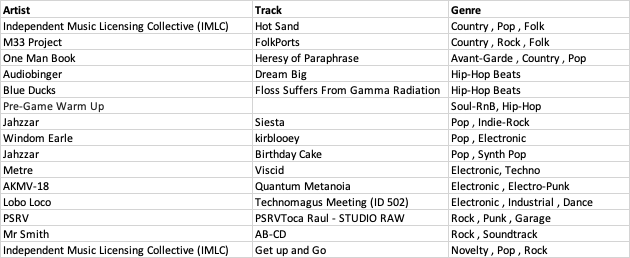!

If starting from scratch (No files in exports) this guide will take you through generating feature vectors to use in the C++ project.

First install third party libs:

In [5]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install librosa
!{sys.executable} -m pip install essentia


  Using cached librosa-0.9.1-py3-none-any.whl (213 kB)
  Using cached resampy-0.2.2-py3-none-any.whl
  Using cached audioread-2.1.9-py3-none-any.whl
  Using cached SoundFile-0.10.3.post1-py2.py3-none-any.whl (21 kB)
  Using cached essentia-2.1b6.dev778-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.7 MB)


### Make sure to run the imports

In [6]:
import numpy as np
import pandas as pd
import os
import essentia.standard as es
import librosa

[   INFO   ] MusicExtractorSVM: no classifier models were configured by default


## Feature Vector Creation

For this we'll be looping through all files in `sample_music` and processing them with some of the out of the box extractors from essentia and librosa.

The goal here is to try to categorize music by using some of its more technical and numeric features:
- loudness
- energy (computed by root mean square average)
- chromagram: illustrates how musically spread out sounds are in a song(To best explain I'll quote Athina B - https://athina-b.medium.com/audio-signal-feature-extraction-for-analysis-507861717dc1) 
>"spectrum is projected onto 12 bins representing the 12 distinct semitones (or chroma) of the musical octave. Since, in music, notes exactly one octave apart are perceived as particularly similar, knowing the distribution of chroma even without the absolute frequency (i.e. the original octave) can give useful musical information about the audio — and may even reveal perceived musical similarity that is not apparent in the original spectra" 

This gives us a pretty hefty 14 feature feature vector so give the below some time to execute (once again if running from scratch - once you have files available in exports you're good to go - unless of course youo change the songs!)

Although this is a lengthy feature vector we'll later see some interesting results in the C++ implementation

**Once this is done processing you'll get a print-out of the raw feature vector**

In [92]:

# assign directory
directory = './sample_music'

feature_vecs = pd.DataFrame()

# iterate over files in
# that directory
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    feature_vec = pd.DataFrame()
    # checking if it is a file
    if os.path.isfile(f):
        
        print('generating features for ' + filename)
        # Compute all features, aggregate only 'mean' and 'stdev' statistics for all low-level, rhythm and tonal frame features
        features, features_frames = es.MusicExtractor(lowlevelStats=['mean', 'stdev'])(f)
        
        #Loading into librosa
        y, sr = librosa.load(f)
        hop_length = 512
        frame_length = 1024
        n_fft = 1
        
        #generating energy and chromagram features
        rmse = librosa.feature.rms(y = y , center=True)
        chromagram = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=hop_length)
        
        print('finished feature generation for ' + filename)
        print('creating feature vector')
        
        song_name = pd.DataFrame({'song': [filename]})
        feature_vec['song'] = song_name
        
        loudness = pd.DataFrame({'loudness': [features['lowlevel.loudness_ebu128.integrated']]})
        feature_vec['loudness'] = loudness
        
        energy_df = pd.DataFrame({'energy': [np.mean(rmse)]})
        feature_vec['energy'] = energy_df
        
        #condensing chromagram data
        chromagram_mean = np.mean(chromagram, axis=1)
        sdict =""
        i=1
        for s in chromagram_mean:
          sdict += "'chroma_{0}':[{1}],".format(i,str(s)) 
          i+=1

        sdict = "{"+sdict+"}"
        
        chroma_df = pd.DataFrame.from_dict(eval(sdict))
        feature_vec[chroma_df.columns] = chroma_df
        
        print('finished creating vector')
        
    print('appending feature vec and clearing for next song')
    feature_vecs = feature_vecs.append(other = feature_vec, ignore_index = True)
    del feature_vec
    
print(feature_vecs)
        

generating features for Independent Music Licensing Collective (IMLC) - Hot Sand.mp3


[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
/opt/conda/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


finished feature generation for Independent Music Licensing Collective (IMLC) - Hot Sand.mp3
creating feature vector
finished creating vector
appending feature vec and clearing for next song
generating features for One Man Book - Heresy of Paraphrase.mp3


[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
/opt/conda/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


finished feature generation for One Man Book - Heresy of Paraphrase.mp3
creating feature vector
finished creating vector
appending feature vec and clearing for next song
generating features for AKMV-18 - Quantum Metanoia.mp3


[   INFO   ] MusicExtractor: Read metadata
/opt/conda/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done


finished feature generation for AKMV-18 - Quantum Metanoia.mp3
creating feature vector
finished creating vector
appending feature vec and clearing for next song
generating features for Metre - Viscid.mp3


[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
/opt/conda/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


finished feature generation for Metre - Viscid.mp3
creating feature vector
finished creating vector
appending feature vec and clearing for next song
generating features for PSRV - Toca Raul - STUDIO RAW.mp3


[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
/opt/conda/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


finished feature generation for PSRV - Toca Raul - STUDIO RAW.mp3
creating feature vector
finished creating vector
appending feature vec and clearing for next song
generating features for M33 Project - FolkPorts.mp3


[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
/opt/conda/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


finished feature generation for M33 Project - FolkPorts.mp3
creating feature vector
finished creating vector
appending feature vec and clearing for next song
generating features for Audiobinger - Pre-Game Warm Up.mp3


[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
/opt/conda/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


finished feature generation for Audiobinger - Pre-Game Warm Up.mp3
creating feature vector
finished creating vector
appending feature vec and clearing for next song
generating features for Mr Smith - AB-CD.mp3


[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
/opt/conda/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


finished feature generation for Mr Smith - AB-CD.mp3
creating feature vector
finished creating vector
appending feature vec and clearing for next song
generating features for Lobo Loco - Technomagus Meeting (ID 502).mp3


[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
/opt/conda/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


finished feature generation for Lobo Loco - Technomagus Meeting (ID 502).mp3
creating feature vector
finished creating vector
appending feature vec and clearing for next song
generating features for Blue Ducks - Floss Suffers From Gamma Radiation.mp3


[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
/opt/conda/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


finished feature generation for Blue Ducks - Floss Suffers From Gamma Radiation.mp3
creating feature vector
finished creating vector
appending feature vec and clearing for next song
generating features for Jahzzar - Siesta.mp3


[   INFO   ] MusicExtractor: Read metadata
/opt/conda/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done


finished feature generation for Jahzzar - Siesta.mp3
creating feature vector
finished creating vector
appending feature vec and clearing for next song
generating features for Jahzzar - Birthday Cake.mp3


[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
/opt/conda/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


finished feature generation for Jahzzar - Birthday Cake.mp3
creating feature vector
finished creating vector
appending feature vec and clearing for next song
generating features for Independent Music Licensing Collective (IMLC) - Get up and Go.mp3


[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
/opt/conda/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


finished feature generation for Independent Music Licensing Collective (IMLC) - Get up and Go.mp3
creating feature vector
finished creating vector
appending feature vec and clearing for next song
generating features for Audiobinger - Dream Big.mp3


[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
/opt/conda/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


finished feature generation for Audiobinger - Dream Big.mp3
creating feature vector
finished creating vector
appending feature vec and clearing for next song
generating features for Windom Earle - kirblooey.mp3


[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
/opt/conda/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


finished feature generation for Windom Earle - kirblooey.mp3
creating feature vector
finished creating vector
appending feature vec and clearing for next song
                                                 song   loudness    energy  \
0   Independent Music Licensing Collective (IMLC) ...  -8.784393  0.274500   
1             One Man Book - Heresy of Paraphrase.mp3 -13.526387  0.140073   
2                      AKMV-18 - Quantum Metanoia.mp3 -13.709229  0.122383   
3                                  Metre - Viscid.mp3 -13.276937  0.148825   
4                   PSRV - Toca Raul - STUDIO RAW.mp3  -0.877343  0.599803   
5                         M33 Project - FolkPorts.mp3 -11.881506  0.152173   
6                  Audiobinger - Pre-Game Warm Up.mp3 -10.930477  0.211538   
7                                Mr Smith - AB-CD.mp3 -14.197141  0.138444   
8        Lobo Loco - Technomagus Meeting (ID 502).mp3 -10.673089  0.238694   
9   Blue Ducks - Floss Suffers From Gamma Radiatio... -11.565

**WARNING THIS BELOW IS A DEBUGGING FEATURE TO DELETE THE CREATED FEATURE VECTOR IF NOT TESTING FEATURE VECTOR IT CAN BE IGNORED**
or you'll have to rerun that long creation step all over again...

In [86]:
del feature_vecs

## Exporting the Features

For ease of reading I'll split the pandas dataframe into the feature vector values (just numbers) and the names. Since the index will maintain the mapping of song to feature vectore I don't have to worry about keeping them together. The last cell will run the export process, the print statement is just to get a fun visual of the different features notice how they aren't to radically different (already not what I'd expect!)

In [105]:
#RUN THIS TO SPLIT BEFORE EXPORT
song_names_df = feature_vecs['song']
song_feats_df = feature_vecs.iloc[:,1:15]

In [104]:
print(song_names_df)
print(song_feats_df)

0     Independent Music Licensing Collective (IMLC) ...
1               One Man Book - Heresy of Paraphrase.mp3
2                        AKMV-18 - Quantum Metanoia.mp3
3                                    Metre - Viscid.mp3
4                     PSRV - Toca Raul - STUDIO RAW.mp3
5                           M33 Project - FolkPorts.mp3
6                    Audiobinger - Pre-Game Warm Up.mp3
7                                  Mr Smith - AB-CD.mp3
8          Lobo Loco - Technomagus Meeting (ID 502).mp3
9     Blue Ducks - Floss Suffers From Gamma Radiatio...
10                                 Jahzzar - Siesta.mp3
11                          Jahzzar - Birthday Cake.mp3
12    Independent Music Licensing Collective (IMLC) ...
13                          Audiobinger - Dream Big.mp3
14                         Windom Earle - kirblooey.mp3
Name: song, dtype: object
     loudness    energy  chroma_1  chroma_2  chroma_3  chroma_4  chroma_5  \
0   -8.784393  0.274500  0.253995  0.366471  0.470985  0.

In [ ]:
song_names_df.to_csv(path_or_buf = './exports/song_names.csv', sep = ',', index = False)
song_feats_df.to_csv(path_or_buf = './exports/song_feats.csv', sep = ',', index = False)